# Here we are implemening Hidden Markov Models for stock price prediction. 
#HMMs have been extensively used for pattern recognition and classification problems because of its proven suitability for modelling dynamic systems

# Loading Library

In [1]:
%matplotlib inline

from __future__ import print_function
import datetime
import numpy as np
import pandas as pd
from matplotlib import cm, pyplot as plt, finance
from matplotlib.dates import YearLocator, MonthLocator
from hmmlearn.hmm import GaussianHMM
import math,statistics
import pandas_datareader.data as web


# Get quotes from Yahoo! finance


In [2]:

ticker = "TSLA"
start_date = datetime.date(2010, 1, 1)
#end_date = datetime.date.today()
end_date = datetime.date.today() - datetime.timedelta(days=15)


In [3]:
quotes= web.DataReader("TSLA", 'yahoo', start_date, end_date)

In [4]:
quotes.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-06-29,19.000000,25.00,17.540001,23.889999,23.889999,18766300
2010-06-30,25.790001,30.42,23.299999,23.830000,23.830000,17187100
2010-07-01,25.000000,25.92,20.270000,21.959999,21.959999,8218800
2010-07-02,23.000000,23.10,18.709999,19.200001,19.200001,5139800
2010-07-06,20.000000,20.00,15.830000,16.110001,16.110001,6866900


# Reset Index

In [5]:
quotes.reset_index(inplace=True,drop=False)
quotes.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-06-29,19.000000,25.00,17.540001,23.889999,23.889999,18766300
1,2010-06-30,25.790001,30.42,23.299999,23.830000,23.830000,17187100
2,2010-07-01,25.000000,25.92,20.270000,21.959999,21.959999,8218800
3,2010-07-02,23.000000,23.10,18.709999,19.200001,19.200001,5139800
4,2010-07-06,20.000000,20.00,15.830000,16.110001,16.110001,6866900


In [6]:
quotes.drop(['Open','High','Low','Adj Close'],axis=1,inplace=True)

In [7]:
quotes.head()

,Date,Close,Volume
0,2010-06-29,23.889999,18766300
1,2010-06-30,23.830000,17187100
2,2010-07-01,21.959999,8218800
3,2010-07-02,19.200001,5139800
4,2010-07-06,16.110001,6866900


# Converting date to ordinal and tupple

In [8]:
quotes['Date'] = quotes['Date'].apply(datetime.datetime.toordinal)

In [9]:
quotes = list(quotes.itertuples(index=False, name=None))

In [10]:
quotes

[(733952, 23.889999, 18766300),
 (733953, 23.829999999999998, 17187100),
 (733954, 21.959999, 8218800),
 (733955, 19.200001, 5139800),
 (733959, 16.110001, 6866900),
 (733960, 15.800000000000001, 6921700),
 (733961, 17.459999, 7711400),
 (733962, 17.399999999999999, 4050600),
 (733965, 17.049999, 2202500),
 (733966, 18.139999, 2680100),
 (733967, 19.84, 4195200),
 (733968, 19.889999, 3739800),
 (733969, 20.639999, 2621300),
 (733972, 21.91, 2486500),
 (733973, 20.299999, 1825300),
 (733974, 20.219998999999998, 1252500),
 (733975, 21.0, 957800),
 (733976, 21.290001, 653600),
 (733979, 20.950001, 922200),
 (733980, 20.549999, 619700),
 (733981, 20.719998999999998, 467200),
 (733982, 20.350000000000001, 616000),
 (733983, 19.940001000000002, 426900),
 (733986, 20.920000000000002, 718100),
 (733987, 21.950001, 1230500),
 (733988, 21.260000000000002, 913000),
 (733989, 20.450001, 796200),
 (733990, 19.59, 741900),
 (733993, 19.600000000000001, 812700),
 (733994, 19.030001000000002, 1281300)

In [11]:
# Unpack quotes
dates = np.array([q[0] for q in quotes], dtype=int)
close_v = np.array([q[1] for q in quotes])
volume = np.array([q[2] for q in quotes])[1:]

In [12]:
# Take diff of close value. Note that this makes
# ``len(diff) = len(close_t) - 1``, therefore, other quantities also
# need to be shifted by 1.
diff = np.diff(close_v)
dates = dates[1:]
close_v = close_v[1:]

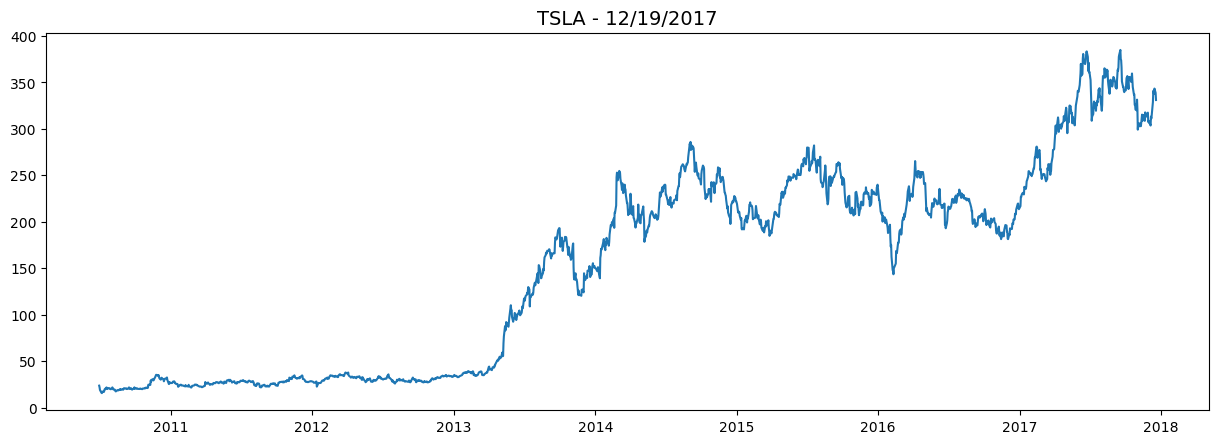

In [13]:
# Pack diff and volume for training.
X = np.column_stack([diff, volume])
plt.figure(figsize=(15, 5), dpi=100) 
plt.title(ticker + " - " + end_date.strftime("%m/%d/%Y"), fontsize = 14)
plt.gca().xaxis.set_major_locator(YearLocator())
plt.plot_date(dates,close_v,"-")
plt.show()

In [14]:
X[0]

array([ -5.99990000e-02,   1.71871000e+07])

In [21]:
###############################################################################
# Run Gaussian HMM
###############################################################################
print("fitting to HMM and decoding ...", end="")
# Make an HMM instance and execute fit
model = GaussianHMM(n_components=3, covariance_type="diag", n_iter=1000).fit(X)
# Predict the optimal sequence of internal hidden state
hidden_states = model.predict(X)
print("done")



fitting to HMM and decoding ...

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The function distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


done


In [22]:
###############################################################################
# Print trained parameters and plot
###############################################################################
print("Transition matrix - probability of going to any particular state")
print(model.transmat_)
print(model.predict_proba)

print("Means and vars of each hidden state")
params = pd.DataFrame(columns=('State', 'Means', 'Variance'))
for i in range(model.n_components):
    params.loc[i] = [format(i), model.means_[i],np.diag(model.covars_[i])]

Transition matrix - probability of going to any particular state
[[  8.48429583e-01   1.09088691e-01   4.24817261e-02]
 [  1.77297388e-01   8.22702612e-01   5.24436221e-57]
 [  4.82208404e-02   3.51758344e-03   9.48261576e-01]]
<bound method _BaseHMM.predict_proba of GaussianHMM(algorithm='viterbi', covariance_type='diag', covars_prior=0.01,
      covars_weight=1, init_params='stmc', means_prior=0, means_weight=0,
      min_covar=0.001, n_components=3, n_iter=1000, params='stmc',
      random_state=None, startprob_prior=1.0, tol=0.01, transmat_prior=1.0,
      verbose=False)>
Means and vars of each hidden state


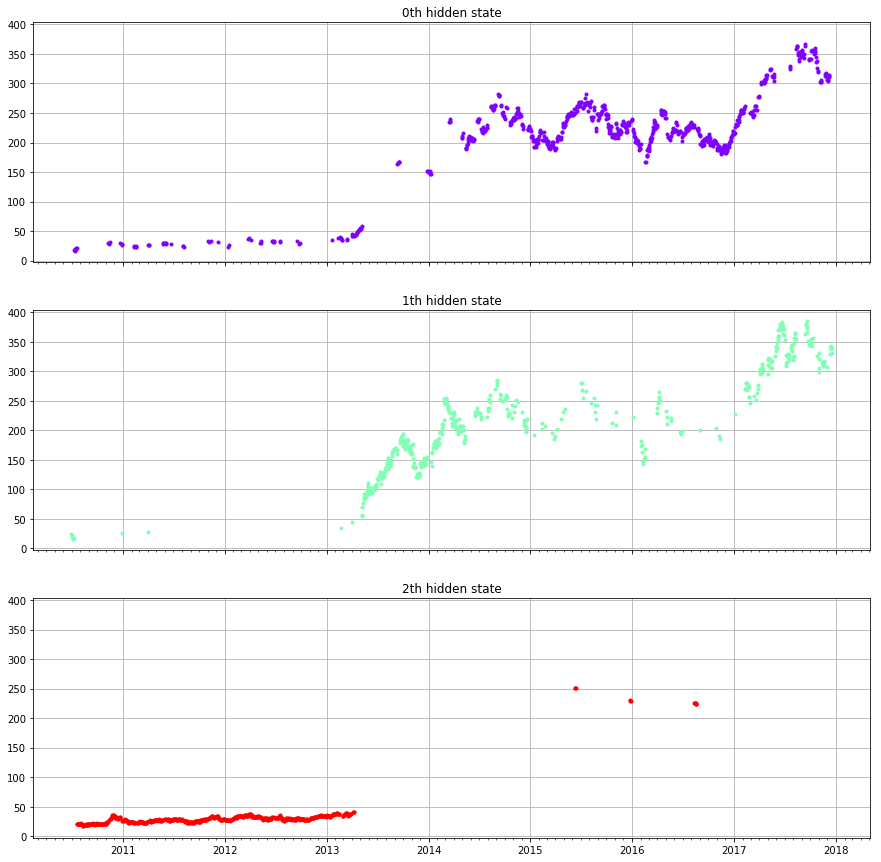

In [23]:
fig, axs = plt.subplots(model.n_components, sharex=True, sharey=True, figsize=(15,15))
colours = cm.rainbow(np.linspace(0, 1, model.n_components))

for i, (ax, colour) in enumerate(zip(axs, colours)):
    # Use fancy indexing to plot data in each state.
    mask = hidden_states == i
    ax.plot_date(dates[mask], close_v[mask], ".", c=colour)
    ax.set_title("{0}th hidden state".format(i))

    # Format the ticks.
    ax.xaxis.set_major_locator(YearLocator())
    ax.xaxis.set_minor_locator(MonthLocator())

    ax.grid(True)
plt.show()



In [24]:


#dot product Transition Matrix to Means to get the expected return and volumes for a particular state
expected_returns_and_volumes = np.dot(model.transmat_, model.means_)
returns_and_volume_columnwise = list(zip(*expected_returns_and_volumes))
expected_returns = returns_and_volume_columnwise[0]
expected_volumes = returns_and_volume_columnwise[1]
params = pd.concat([pd.Series(expected_returns), pd.Series(expected_volumes)], axis=1)
params.columns= ['Returns', 'Volume']
print (params)



    Returns        Volume
0  0.278328  4.541995e+06
1  0.142568  8.700978e+06
2  0.038845  1.221612e+06


In [25]:


#get quotes for last N days
lastN = 7
start_date = datetime.date.today() - datetime.timedelta(days=lastN*2) #even beyond N days
end_date = datetime.date.today() 

dates = np.array([q[0] for q in quotes], dtype=int)



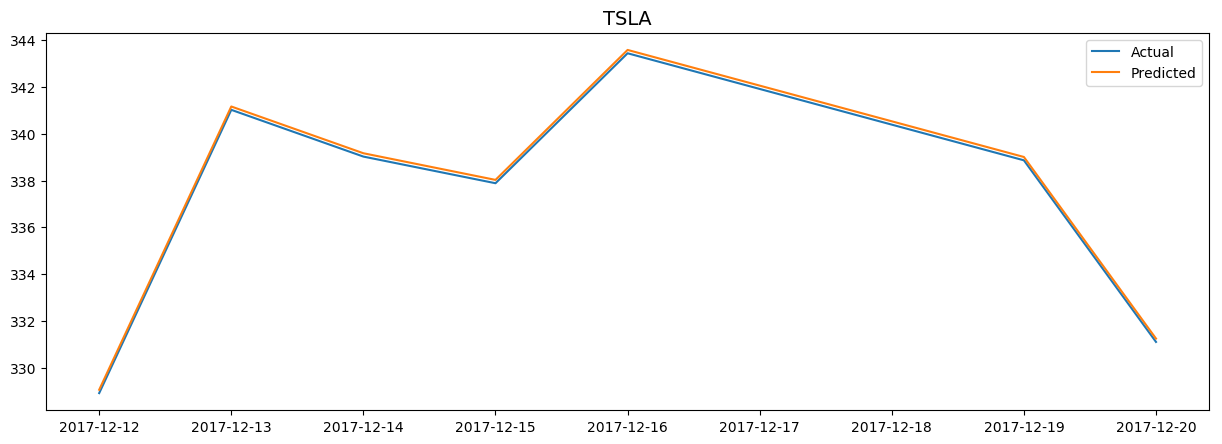

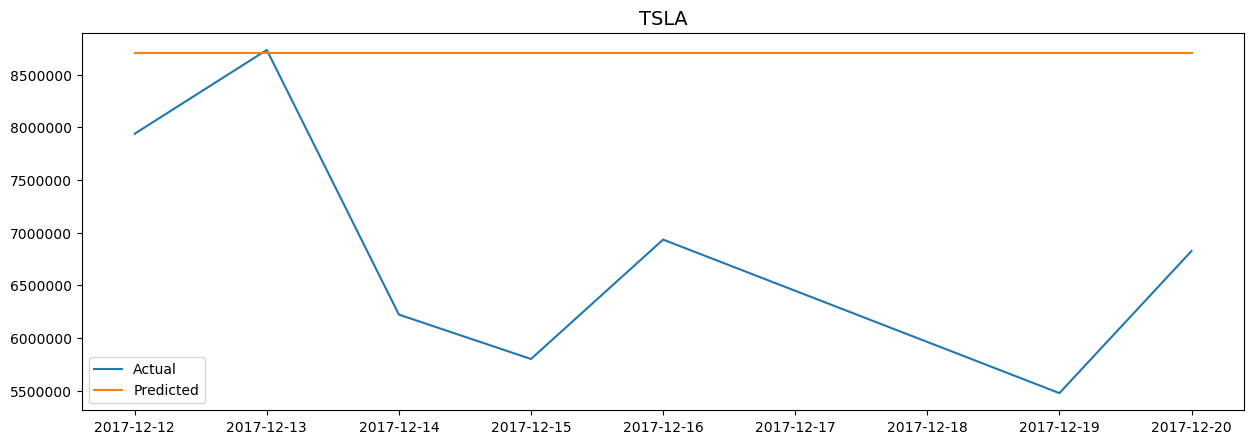

In [26]:
predicted_prices = []
predicted_dates = []
predicted_volumes = []
actual_volumes = []

for idx in range(lastN):
    state = hidden_states[-lastN+idx]
    current_price = quotes[-lastN+idx][1]
    volume = quotes[-lastN+idx][2]
    actual_volumes.append(volume)
    current_date = datetime.date.fromordinal(dates[-lastN+idx])
    predicted_date = current_date + datetime.timedelta(days=1)
    predicted_dates.append(predicted_date)
    predicted_prices.append(current_price + expected_returns[state])
    predicted_volumes.append(np.round(expected_volumes[state]))    

#Returns
plt.figure(figsize=(15, 5), dpi=100) 
plt.title(ticker, fontsize = 14)
plt.plot(predicted_dates,close_v[-lastN:])
plt.plot(predicted_dates,predicted_prices)
plt.legend(['Actual','Predicted'])
plt.show()

#Volumes
plt.figure(figsize=(15, 5), dpi=100) 
plt.title(ticker, fontsize = 14)
plt.plot(predicted_dates,actual_volumes)
plt.plot(predicted_dates,predicted_volumes)
plt.legend(['Actual','Predicted'])
plt.show()

In [28]:
Actual=close_v[-lastN:]



# Forecasting Techniq Metrics Forecasting error, mse, rmse, bias

In [29]:
#predictions = [0.2, 0.4, 0.1, 0.6, 0.2]
forecast_errors = [Actual[i]- predicted_prices[i] for i in range(len(predicted_prices))]
#print('Forecast Errors: %s' % forecast_errors)
mean_forecast_error = statistics.mean(forecast_errors)
mean_forecast_error

-0.14256844092733445

In [30]:
bias = sum(forecast_errors) * 1.0/len(predicted_prices)
print('Bias: %f' % bias)

Bias: -0.142568


In [31]:
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(Actual, predicted_prices)
print('MSE: %f' % mse)

MSE: 0.020326


In [32]:
rmse = math.sqrt(mse)
print('RMSE: %f' % rmse)

RMSE: 0.142568
